# Objetivo

Identificar a melhor relação entre as variáveis explicativas e a resposta por uma função, Y = F(X|$\theta$). A priori, tem-se interesse em atingir todos os clientes classificados como churn, como descrito na contextualização do README.

Nesse contexto, faria sentido pensar em métricas como maximizar o recall (taxa de verdadeiro positivo) dado que o custo de se ter um falso negativo é caro. Mas, também precisa ser levado em consideração que o gasto com um público que é falso positivo é comprometedor para a campanha, ou seja, um gasto desnecessário foi feito.

# Pacotes

In [60]:
#!pip install mlflow
#!pip install xgboost
#!pip install shap

In [68]:
# Precisei fazer o downgrade do numpy, por conflito de versão com o numba.
    # https://medium.com/@pies052022/importerror-numba-needs-numpy-1-21-or-less-solved-7bc8690a19a5

#!pip install numpy==2.0

In [14]:
from deltalake import DeltaTable, write_deltalake
import mlflow
from mlflow.models import infer_signature
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import shap
import Funcoes
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score, accuracy_score, average_precision_score, brier_score_loss, confusion_matrix, classification_report, ConfusionMatrixDisplay
import xgboost as xgb

In [3]:
# Valida a versão do numpy

print(np.__version__)

2.0.0


# Leitura da base v1

In [4]:
dados = DeltaTable("../1.Variaveis/tmp/dados_pp_v1").to_pandas()
dados.drop(['__index_level_0__'], axis=1, inplace=True)
dados.head()

,Customer_Age,Dependent_count,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Total_Revolving_Bal,Total_Amt_Chng_Q4_Q1,Total_Ct_Chng_Q4_Q1,vfm,pmcc,...,Income_Category_5. >= 120k,Card_Category_Gold,Card_Category_Platinum,Card_Category_Silver,Education_Level_v2_1.Uneducated,Education_Level_v2_2.High School,Education_Level_v2_3.Graduate,Education_Level_v2_4.Post-Graduate,Attrition_Flag,type
0,-0.784196,0.494019,1.403132,-1.337898,0.498943,0.963894,0.282975,-0.328225,-0.175537,-0.421450,...,0,0,0,0,0,0,1,0,0,Treino
1,0.720070,0.494019,-0.525933,0.641818,1.408428,-0.165769,-1.527806,-0.194304,-0.208685,-1.054789,...,0,0,0,0,0,0,1,0,0,Treino
2,1.346848,0.494019,-0.525933,-0.348040,0.498943,0.864865,0.894171,0.056797,-0.571459,-0.686436,...,0,0,0,0,0,0,0,1,0,Treino
3,0.218648,-0.279306,-0.525933,0.641818,-1.320028,-0.412731,0.369637,0.851953,0.252749,2.406712,...,0,0,0,0,0,0,1,0,0,Treino
4,-2.539173,-1.825958,0.117089,1.631675,1.408428,-0.858972,0.346832,-1.144306,-0.064053,-0.071911,...,0,0,0,0,1,0,0,0,0,Treino


In [3]:
dados.dtypes

Customer_Age                          float64
Dependent_count                       float64
Total_Relationship_Count              float64
Months_Inactive_12_mon                float64
Contacts_Count_12_mon                 float64
Total_Revolving_Bal                   float64
Total_Amt_Chng_Q4_Q1                  float64
Total_Ct_Chng_Q4_Q1                   float64
vfm                                   float64
pmcc                                  float64
Gender_M                                int32
Marital_Status_Married                  int32
Marital_Status_Single                   int32
Marital_Status_Unknown                  int32
Income_Category_1.< 40k                 int32
Income_Category_2. >= 40k & < 60k       int32
Income_Category_3. >= 60k & < 80k       int32
Income_Category_4. >= 80k & < 120k      int32
Income_Category_5. >= 120k              int32
Card_Category_Gold                      int32
Card_Category_Platinum                  int32
Card_Category_Silver              

## Separação das bases

Se classificássemos toda a base como "não churn" ou Attrition_Flag = 0, teríamos a métrica de acurácia em aproximadamente 83%. Utilizaremos esse valor como threshold, além de avaliar outras métricas como recall (TPR), precisão e FPR.

In [5]:
dados_treino = dados[dados.type == 'Treino'].drop(['type'], axis=1)
dados_val = dados[dados.type == 'Validacao'].drop(['type'], axis=1)
dados_teste = dados[dados.type == 'Teste'].drop(['type'], axis=1)

In [6]:
X_treino = dados_treino.drop(['Attrition_Flag'], axis=1)
y_treino = dados_treino['Attrition_Flag']

X_val = dados_val.drop(['Attrition_Flag'], axis=1)
y_val = dados_val['Attrition_Flag']

In [9]:
# A representatividade absoluta da variável target é baixa nas bases de validação e teste

dados_treino['Attrition_Flag'].value_counts(), dados_val['Attrition_Flag'].value_counts(), dados_teste['Attrition_Flag'].value_counts()

(Attrition_Flag
 0    6140
 1    1175
 Name: count, dtype: int64,
 Attrition_Flag
 0    1084
 1     208
 Name: count, dtype: int64,
 Attrition_Flag
 0    1276
 1     244
 Name: count, dtype: int64)

In [11]:
dados_treino['Attrition_Flag'].value_counts()/dados_treino.shape[0], dados_val['Attrition_Flag'].value_counts()/dados_val.shape[0], dados_teste['Attrition_Flag'].value_counts()/dados_teste.shape[0]

(Attrition_Flag
 0    0.839371
 1    0.160629
 Name: count, dtype: float64,
 Attrition_Flag
 0    0.839009
 1    0.160991
 Name: count, dtype: float64,
 Attrition_Flag
 0    0.839474
 1    0.160526
 Name: count, dtype: float64)

# Modelos baselines 

Por hora, aplicaremos alguns modelos sem a tunagem dos hiperparâmetros, considerando todas as variáveis e avaliaremos o desempenho na base de validação.

## Cria experimento

In [10]:
#experiment = mlflow.create_experiment(name = 'Modelos_Baselines',
#                                      artifact_location = 'Artf_Modelos_Baselies',
#                                      tags = {'Environment': 'Development', 'Version': '1.0.0'}
#                                      )

In [11]:
#experiment

'409923951546246489'

In [7]:
experiment = mlflow.set_experiment(experiment_id='409923951546246489')

In [8]:
experiment.experiment_id

'409923951546246489'

## Random forest

Pelas métricas de treino e validação, é possível identificar que o modelo se sobreajustou. A métrica AUC-PR mostra que se perde cerca de 20% da área sobre esta curva quando se compara validação (80%) e treino (100%).

In [14]:
if __name__ == '__main__':
    
    with mlflow.start_run(run_name = 'Baseline_RF', experiment_id = experiment.experiment_id) as run: 

        rf = RandomForestClassifier()
        rf.fit(X_treino, y_treino)

        # Log dos parâmetros do modelo
        mlflow.log_params(rf.get_params())

        # Log das métricas na base de TREINO
        mlflow.log_metric('AUC_PR_Treino', average_precision_score(y_treino, rf.predict_proba(X_treino)[:,1]))
        mlflow.log_metric('AUC_ROC_Treino', roc_auc_score(y_treino, rf.predict_proba(X_treino)[:,1]))
        mlflow.log_metric('BS_Treino', brier_score_loss(y_treino, rf.predict_proba(X_treino)[:,1]))

            # OBS: o ponto de corte utilizado é o 0.5 (ainda não otimizamos esse ponto)
        mlflow.log_metric('F1_Treino', f1_score(y_treino, rf.predict(X_treino)))
        mlflow.log_metric('Precision_Treino', precision_score(y_treino, rf.predict(X_treino)))
        mlflow.log_metric('Recall_Treino', recall_score(y_treino, rf.predict(X_treino)))
        mlflow.log_metric('Acuracia_Treino', accuracy_score(y_treino, rf.predict(X_treino)))

        # Log das métricas na base de VALIDAÇÃO
        mlflow.log_metric('AUC_PR_Val', average_precision_score(y_val, rf.predict_proba(X_val)[:,1]))
        mlflow.log_metric('AUC_ROC_Val', roc_auc_score(y_val, rf.predict_proba(X_val)[:,1]))
        mlflow.log_metric('BS_Val', brier_score_loss(y_val, rf.predict_proba(X_val)[:,1]))

                    # OBS: o ponto de corte utilizado é o 0.5 (ainda não otimizamos esse ponto)
        mlflow.log_metric('F1_Val', f1_score(y_val, rf.predict(X_val)))
        mlflow.log_metric('Precision_Val', precision_score(y_val, rf.predict(X_val)))
        mlflow.log_metric('Recall_Val', recall_score(y_val, rf.predict(X_val)))
        mlflow.log_metric('Acuracia_Val', accuracy_score(y_val, rf.predict(X_val)))
        
        # Log do schema das variáveis do modelo e do modelo
        signature = infer_signature(X_treino, rf.predict_proba(X_treino))
        mlflow.sklearn.log_model(rf, signature=signature, artifact_path='modelo')

/home/hugo/Documents/Git_GitHub/Estudo_Cartao_Credito/vCartao_Credito/lib/python3.12/site-packages/mlflow/types/utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


In [9]:
logged_model = 'runs:/46f1b5c5341142b69a7e3ec7317f9993/modelo'

# Carrega o modelo com a flavor da sklearn
rf = mlflow.sklearn.load_model(logged_model)

# Predict on a Pandas DataFrame.
rf.predict_proba(X_treino)

array([[1.  , 0.  ],
       [0.9 , 0.1 ],
       [0.98, 0.02],
       ...,
       [0.96, 0.04],
       [0.98, 0.02],
       [1.  , 0.  ]])

### Importância das variáveis

As duas primeiras variáveis mais importantes coincidem com as variáveis mais importantes em termos de IV. Além disso, identifica-se que as 12 primeiras variáveis acumulam cerca de 91% de importância. 

In [10]:
np.cumsum(np.sort(rf.feature_importances_)[::-1])

array([0.19940778, 0.36248545, 0.46540322, 0.56394182, 0.65723644,
       0.71527244, 0.7720982 , 0.82617013, 0.86997731, 0.89719866,
       0.90855356, 0.91839887, 0.92798364, 0.93742017, 0.94577973,
       0.95354765, 0.96065928, 0.96731936, 0.97354924, 0.97902821,
       0.98430525, 0.98935835, 0.99433515, 0.99792843, 0.99976263,
       1.        ])

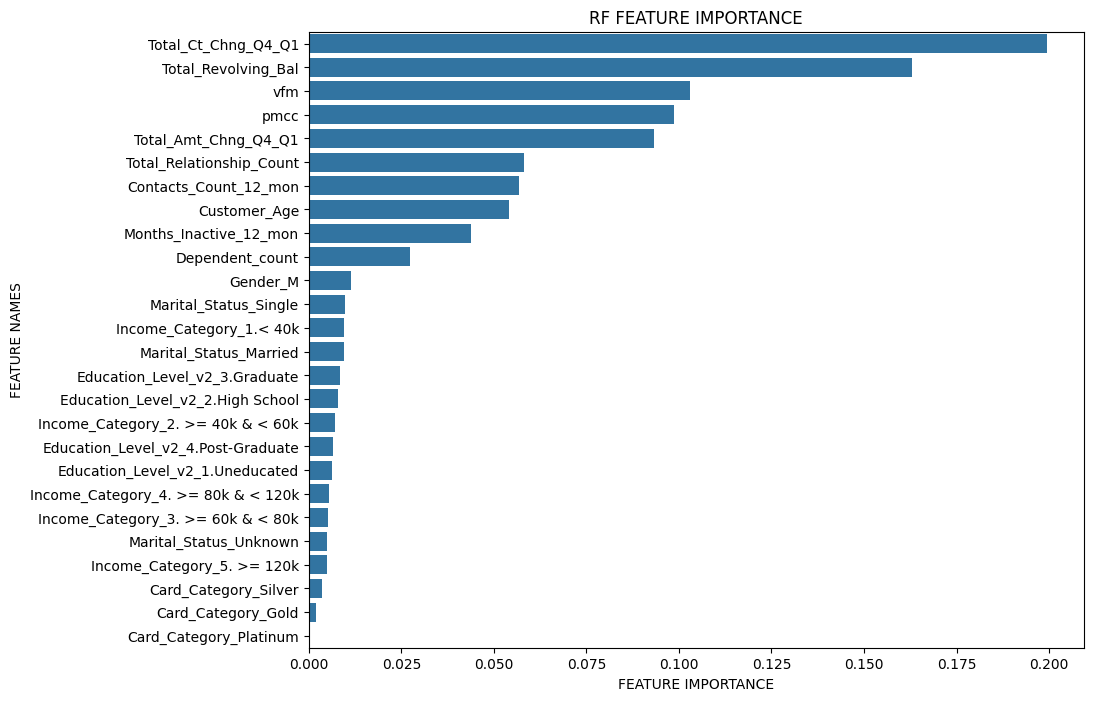

In [11]:
Funcoes.plot_feature_importance(rf.feature_importances_, rf.feature_names_in_, 'RF')

### Curva de calibração e histograma das probabilidades preditas

O histograma abaixo mostra a distrbuição dos valores preditos. A maior concentração está próxima de zero, porque a base está concentrada em clientes que não são churn. Mas, também é possível ver uma pequena concentração de clientes em valores preditos maiores. 

Pelo gráfico de calibração, os primeiros 8 decis estão superestimados em média. Entretanto, pelo histograma são as menores probabilidades encontradas e potencialmente são so clientes que não são churn.

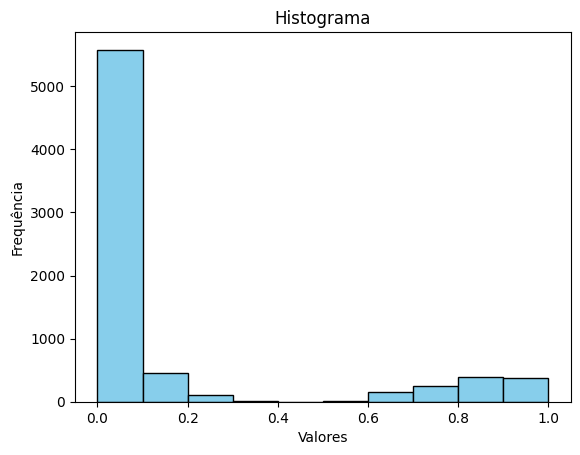

In [41]:
Funcoes.plot_histograma('Prob_predita', pd.DataFrame(rf.predict_proba(X_treino)[:,1]).rename(columns={0: 'Prob_predita'}), label=None)

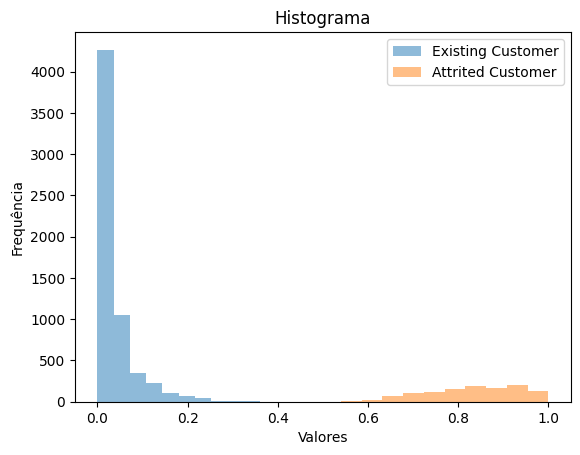

In [52]:
Funcoes.plot_histograma('Prob_predita', pd.concat([pd.Series(rf.predict_proba(X_treino)[:,1]).reset_index(drop = True), y_treino.reset_index(drop = True)], axis=1).rename(columns={0: 'Prob_predita'}), label='Attrition_Flag')

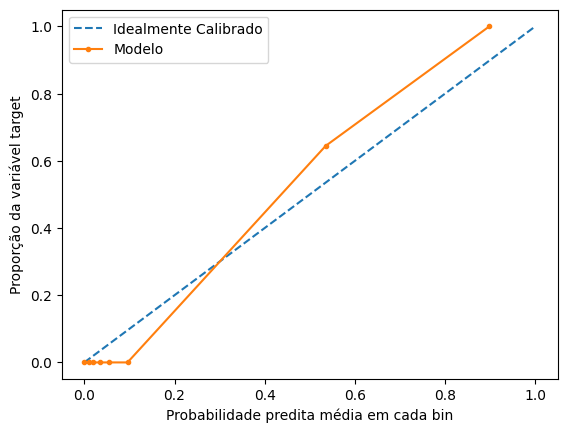

In [26]:
Funcoes.grafico_calibracao(y_treino, rf.predict_proba(X_treino)[:,1], nbins=10, strategy='quantile')

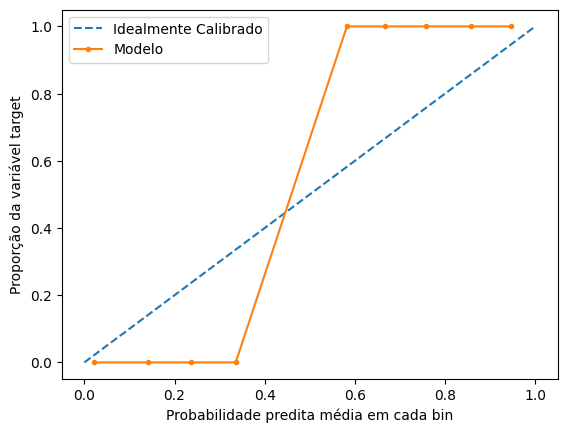

In [57]:
Funcoes.grafico_calibracao(y_treino, rf.predict_proba(X_treino)[:,1], nbins=10, strategy='uniform')

Abaixo, identica-se que a distribuição das probabilidades preditas são um pouco diferentes comparada com a base de treino. Agora, comete-se alguns erros como é possível notar o histograma graficado com base na cor da variável target. 

Como na base de validação (e de teste) a quantidade de clientes churn é baixa em valores absolutos, a curva de calibração por decil pode ficar distorcida como é mostrada abaixo, pois preserva-se a mesma quantidade de clientes em cada intervalo, mas isso não garante a mesma distribuição de churn em cada decil. Ao usar o parâmetro uniforme, garante-se o mesmo comprimento de intervalo dos valores preditos, o que pode suavizar a curva analisada. Entretanto, é possível avaliar que os últimos intervalos estão subestimados. 

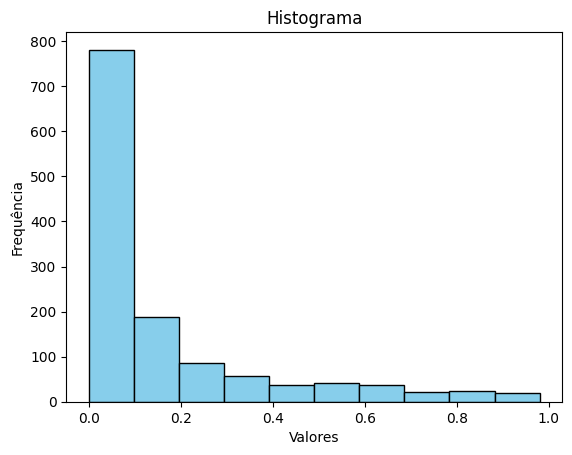

In [42]:
Funcoes.plot_histograma('Prob_predita', pd.DataFrame(rf.predict_proba(X_val)[:,1]).rename(columns={0: 'Prob_predita'}), label=None)

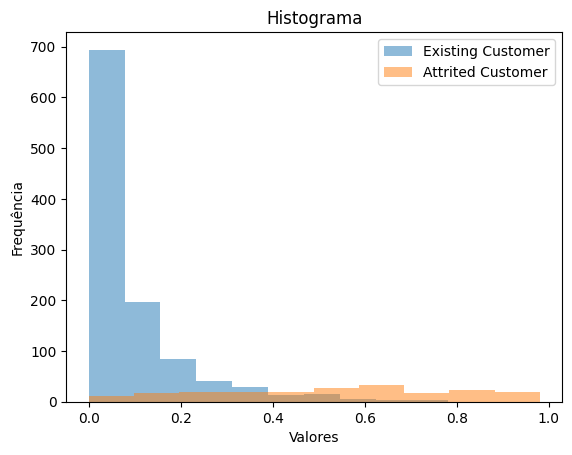

In [51]:
Funcoes.plot_histograma('Prob_predita', pd.concat([pd.Series(rf.predict_proba(X_val)[:,1]).reset_index(drop = True), pd.Series(y_val).reset_index(drop = True)], axis=1).rename(columns={0: 'Prob_predita'}), label='Attrition_Flag')

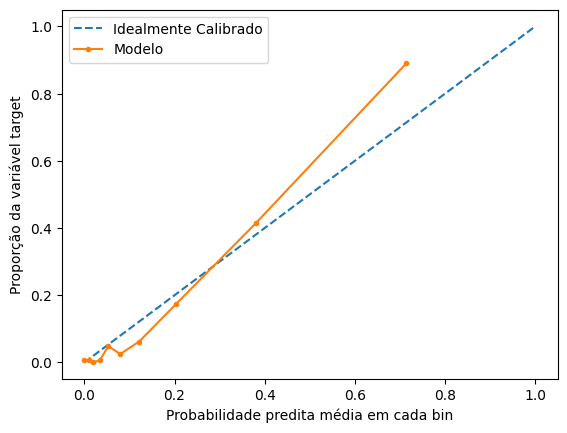

In [56]:
Funcoes.grafico_calibracao(y_val, rf.predict_proba(X_val)[:,1], nbins=10, strategy='quantile')

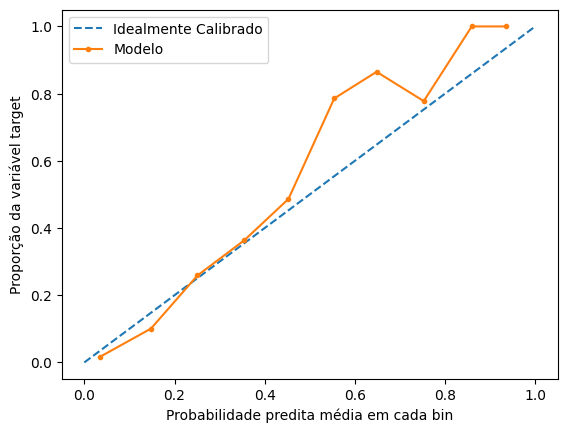

In [55]:
Funcoes.grafico_calibracao(y_val, rf.predict_proba(X_val)[:,1], nbins=10, strategy='uniform')

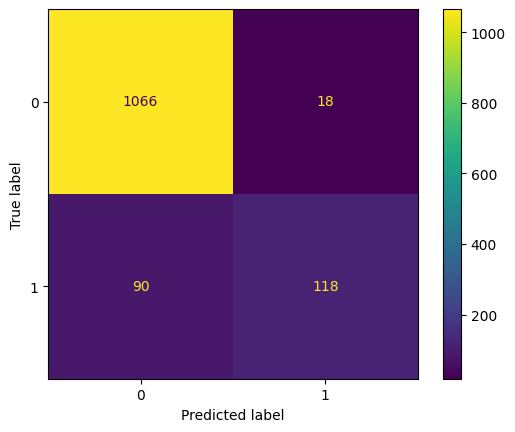

In [18]:
confusion_matrix = confusion_matrix(y_val, rf.predict(X_val))
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])

cm_display.plot()
plt.show()

In [30]:
print(classification_report(y_val, rf.predict(X_val)))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1084
           1       0.87      0.57      0.69       208

    accuracy                           0.92      1292
   macro avg       0.89      0.78      0.82      1292
weighted avg       0.91      0.92      0.91      1292



### Interpretabilidade

In [23]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer(X_val)

In [24]:
shap_values

.values =
array([[[-2.64234526e-03,  2.64234526e-03],
        [-6.62743666e-03,  6.62743666e-03],
        [ 3.36669722e-02, -3.36669722e-02],
        ...,
        [-3.19945958e-03,  3.19945958e-03],
        [-1.60057840e-03,  1.60057840e-03],
        [ 2.12807979e-03, -2.12807979e-03]],

       [[ 1.69147035e-02, -1.69147035e-02],
        [-5.57137427e-03,  5.57137427e-03],
        [ 3.22320632e-02, -3.22320632e-02],
        ...,
        [ 1.56327217e-03, -1.56327217e-03],
        [-1.04962433e-03,  1.04962433e-03],
        [ 1.11205620e-03, -1.11205620e-03]],

       [[-7.06972763e-03,  7.06972763e-03],
        [-6.38263326e-03,  6.38263326e-03],
        [-1.07110881e-01,  1.07110881e-01],
        ...,
        [ 1.10978520e-02, -1.10978520e-02],
        [-3.07546112e-04,  3.07546112e-04],
        [ 1.41623083e-03, -1.41623083e-03]],

       ...,

       [[ 4.21989295e-03, -4.21989295e-03],
        [ 1.30630940e-03, -1.30630940e-03],
        [ 1.12851263e-02, -1.12851263e-02],
        

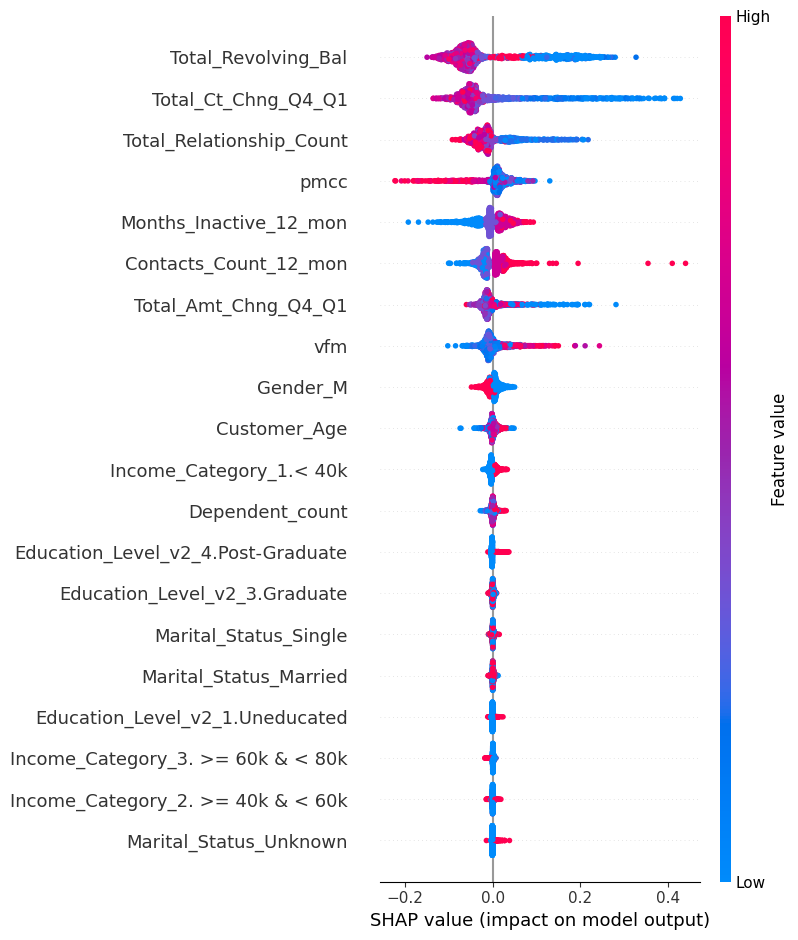

In [48]:
shap.summary_plot(shap_values.values[:,:,1], X_val)